# Сравнение моделей для предсказания STOI

Этот ноутбук загружает все обученные модели, тестирует их на тестовом датасете и строит графики для сравнения.


In [4]:
import os
import sys
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import json
from datetime import datetime

# Добавляем путь к src для импорта модулей
# В Jupyter ноутбуке используем текущую рабочую директорию
project_root = os.getcwd()
src_path = os.path.join(project_root, 'src')

# Проверяем существование директории src
if not os.path.exists(src_path):
    # Пробуем найти src относительно текущей директории
    if os.path.basename(project_root) != 'speech_intelligibility_assessment':
        # Если мы не в корне проекта, пробуем найти его
        possible_paths = [
            os.path.join(project_root, 'src'),
            os.path.join(os.path.dirname(project_root), 'src'),
            os.path.join(project_root, '..', 'src'),
        ]
        for path in possible_paths:
            abs_path = os.path.abspath(path)
            if os.path.exists(abs_path):
                src_path = abs_path
                break

if not os.path.exists(src_path):
    raise FileNotFoundError(f"Не найдена директория src. Текущая директория: {project_root}")

# Добавляем в sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Импортируем из локального модуля, используя importlib для избежания конфликтов с установленными пакетами
import importlib.util

# Импорт dataset
dataset_file = os.path.join(src_path, "dataset.py")
if os.path.exists(dataset_file):
    spec = importlib.util.spec_from_file_location("local_dataset", dataset_file)
    dataset_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dataset_module)
    STOIDataset = dataset_module.STOIDataset
else:
    raise FileNotFoundError(f"Не найден файл: {dataset_file}")

# Импорт model
model_file = os.path.join(src_path, "model.py")
if os.path.exists(model_file):
    spec = importlib.util.spec_from_file_location("local_model", model_file)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)
    TransformerSTOIPredictor = model_module.TransformerSTOIPredictor
    LSTMSTOIPredictor = model_module.LSTMSTOIPredictor
    CNNSTOIPredictor = model_module.CNNSTOIPredictor
else:
    raise FileNotFoundError(f"Не найден файл: {model_file}")

print(f"✓ Модули загружены из: {src_path}")

warnings.filterwarnings("ignore", message=".*None of the inputs have requires_grad=True.*")

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Проверка устройства
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


✓ Модули загружены из: /home/danya/develop/speech_intelligibility_assessment/src
Используется устройство: cuda
GPU: NVIDIA GeForce RTX 5060 Ti
Память GPU: 16.62 GB


## Настройка параметров


In [5]:
# Параметры
CHECKPOINTS_DIR = './checkpoints_all_models'
AUDIO_DIR = '/home/danya/datasets/CMU-MOSEI/Audio/'
ORIGINAL_DIR = '/home/danya/datasets/CMU-MOSEI/Audio/WAV_16000/'
OUTPUT_DIR = './comparison_results'
BATCH_SIZE = 16
SAMPLE_RATE = 16000
MAX_LENGTH = 10.0
MAX_SAMPLES = None  # None для использования всех данных

# Модели для тестирования
MODELS_TO_TEST = ['transformer', 'lstm', 'cnn']

# Создаем директорию для результатов
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Параметры:")
print(f"  Checkpoints dir: {CHECKPOINTS_DIR}")
print(f"  Audio dir: {AUDIO_DIR}")
print(f"  Output dir: {OUTPUT_DIR}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Models to test: {MODELS_TO_TEST}")


Параметры:
  Checkpoints dir: ./checkpoints_all_models
  Audio dir: /home/danya/datasets/CMU-MOSEI/Audio/
  Output dir: ./comparison_results
  Batch size: 16
  Models to test: ['transformer', 'lstm', 'cnn']


## Загрузка тестового датасета


In [6]:
print("Загрузка тестового датасета...")
print(f"Базовая директория: {AUDIO_DIR}")
print("Ищем файлы в поддиректориях: noise, reverb, noise_reverb, extreme_stoi")

dataset = STOIDataset(
    audio_dir=AUDIO_DIR,
    original_dir=ORIGINAL_DIR,
    sample_rate=SAMPLE_RATE,
    max_length_seconds=MAX_LENGTH,
    use_wav2vec=False,
    subdirs=['noise', 'reverb', 'noise_reverb', 'extreme_stoi']
)

print(f"Всего образцов в датасете: {len(dataset)}")

# Ограничиваем размер датасета, если указано
if MAX_SAMPLES is not None and MAX_SAMPLES > 0:
    if MAX_SAMPLES < len(dataset):
        print(f"Ограничиваем датасет до {MAX_SAMPLES} образцов")
        indices = torch.randperm(len(dataset))[:MAX_SAMPLES].tolist()
        dataset = torch.utils.data.Subset(dataset, indices)
        print(f"Используется {len(dataset)} образцов")

# Создаем DataLoader
test_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True if device == 'cuda' else False,
    persistent_workers=True if device == 'cuda' else False
)

print(f"Тестовых образцов: {len(dataset)}")
print(f"Количество батчей: {len(test_loader)}")


Загрузка тестового датасета...
Базовая директория: /home/danya/datasets/CMU-MOSEI/Audio/
Ищем файлы в поддиректориях: noise, reverb, noise_reverb
Найдено 3842 аудио файлов в /home/danya/datasets/CMU-MOSEI/Audio/noise
Найдено 3842 аудио файлов в /home/danya/datasets/CMU-MOSEI/Audio/reverb
Найдено 3842 аудио файлов в /home/danya/datasets/CMU-MOSEI/Audio/noise_reverb
Всего найдено 11526 аудио файлов
Найдено 11526 валидных файлов
Загружен кэш STOI из /home/danya/datasets/CMU-MOSEI/Audio/.stoi_cache.pkl (3842 записей)


Вычисление STOI: 100%|██████████| 11526/11526 [53:49<00:00,  3.57it/s]  

Вычислено 7684 новых значений STOI
Кэш STOI сохранен в /home/danya/datasets/CMU-MOSEI/Audio/.stoi_cache.pkl
Всего образцов в датасете: 11526
Тестовых образцов: 11526
Количество батчей: 721


## Функция для тестирования модели


In [7]:
def test_model(model, dataloader, device, model_name):
    """Тестирование модели и возврат результатов"""
    model.eval()
    all_preds = []
    all_targets = []
    
    if device == 'cuda':
        torch.cuda.empty_cache()
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f'Testing {model_name}')
        for batch_idx, batch in enumerate(pbar):
            waveform = batch['waveform'].to(device, non_blocking=True)
            features = batch['features'].to(device, non_blocking=True)
            stoi_true = batch['stoi'].to(device, non_blocking=True)
            
            # Убеждаемся, что данные contiguous
            waveform = waveform.contiguous()
            features = features.contiguous()
            
            # Forward pass
            stoi_pred = model(waveform, features)
            
            # Убеждаемся, что размеры правильные
            stoi_pred_flat = stoi_pred.view(-1)
            stoi_true_flat = stoi_true.view(-1)
            
            # Сохраняем результаты
            preds_np = stoi_pred_flat.cpu().numpy()
            targets_np = stoi_true_flat.cpu().numpy()
            
            all_preds.extend(preds_np.tolist())
            all_targets.extend(targets_np.tolist())
            
            if device == 'cuda' and (batch_idx + 1) % 50 == 0:
                torch.cuda.empty_cache()
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Вычисляем метрики
    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    correlation = np.corrcoef(all_preds, all_targets)[0, 1]
    
    # Вычисляем процент ошибок в пределах порогов
    thresholds = [0.05, 0.10, 0.15, 0.20]
    accuracy_at_threshold = {}
    for threshold in thresholds:
        within_threshold = np.abs(all_preds - all_targets) <= threshold
        accuracy_at_threshold[threshold] = np.mean(within_threshold) * 100
    
    return {
        'predictions': all_preds,
        'targets': all_targets,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'correlation': correlation,
        'accuracy_at_threshold': accuracy_at_threshold
    }


In [9]:
# Определяем конфигурацию моделей
models_config = {
    'transformer': {
        'class': TransformerSTOIPredictor,
        'checkpoint': 'best_transformer.pt'
    },
    'lstm': {
        'class': LSTMSTOIPredictor,
        'checkpoint': 'best_lstm.pt'
    },
    'cnn': {
        'class': CNNSTOIPredictor,
        'checkpoint': 'best_cnn.pt'
    }
}

# Словарь для хранения результатов
all_results = {}
model_info = {}

# Загружаем и тестируем каждую модель
for model_name in MODELS_TO_TEST:
    if model_name not in models_config:
        print(f"Пропускаем неизвестную модель: {model_name}")
        continue
    
    config = models_config[model_name]
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, config['checkpoint'])
    
    if not os.path.exists(checkpoint_path):
        print(f"⚠️  Чекпоинт не найден: {checkpoint_path}")
        continue
    
    print(f"\n{'='*80}")
    print(f"Загрузка модели: {model_name.upper()}")
    print(f"{'='*80}")
    
    # Загружаем чекпоинт
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Проверяем, что имя модели в чекпоинте совпадает
    checkpoint_model_name = checkpoint.get('model_name', model_name)
    if checkpoint_model_name != model_name:
        print(f"⚠️  Предупреждение: имя модели в чекпоинте ({checkpoint_model_name}) не совпадает с ожидаемым ({model_name})")
    
    # Создаем модель с параметрами из чекпоинта
    model_kwargs = checkpoint.get('model_kwargs', {})
    if not model_kwargs:
        print(f"⚠️  Предупреждение: model_kwargs не найдены в чекпоинте, используем значения по умолчанию")
    
    # Для LSTM модели проверяем размер downsampling в чекпоинте
    if model_name == 'lstm':
        state_dict = checkpoint['model_state_dict']
        if 'downsample.weight' in state_dict:
            downsample_weight = state_dict['downsample.weight']
            # Определяем kernel_size из размера весов: [out_channels, in_channels, kernel_size]
            checkpoint_kernel_size = downsample_weight.shape[2]
            print(f"  Определен kernel_size для downsampling из чекпоинта: {checkpoint_kernel_size}")
            
            # Создаем модель сначала
            model = config['class'](**model_kwargs).to(device)
            
            # Проверяем текущий kernel_size модели
            current_kernel_size = model.downsample.kernel_size[0]
            
            if checkpoint_kernel_size != current_kernel_size:
                print(f"  ⚠️  Несоответствие kernel_size: чекпоинт={checkpoint_kernel_size}, модель={current_kernel_size}")
                print(f"  Создаем новый downsampling с правильным размером...")
                
                # Создаем новый downsampling с правильным размером
                import torch.nn as nn
                input_dim = model_kwargs.get('input_dim', 1)
                model.downsample = nn.Conv1d(
                    in_channels=input_dim,
                    out_channels=input_dim,
                    kernel_size=checkpoint_kernel_size,
                    stride=checkpoint_kernel_size,
                    padding=0
                ).to(device)
        else:
            model = config['class'](**model_kwargs).to(device)
    else:
        model = config['class'](**model_kwargs).to(device)
    
    # Загружаем веса
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    except RuntimeError as e:
        if 'size mismatch' in str(e):
            print(f"⚠️  Обнаружено несоответствие размеров. Пытаемся загрузить с strict=False...")
            missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            if missing_keys:
                print(f"⚠️  Пропущенные ключи: {missing_keys}")
            if unexpected_keys:
                print(f"⚠️  Неожиданные ключи: {unexpected_keys}")
        else:
            raise
    
    # Сохраняем информацию о модели
    epoch = checkpoint.get('epoch', 'unknown')
    val_loss = checkpoint.get('val_loss', 'unknown')
    val_mae = checkpoint.get('val_mae', 'unknown')
    
    model_info[model_name] = {
        'epoch': epoch,
        'val_loss': val_loss,
        'val_mae': val_mae,
        'checkpoint_path': checkpoint_path
    }
    
    print(f"✓ Модель загружена:")
    print(f"  - Эпоха: {epoch}")
    print(f"  - Val Loss: {val_loss:.4f}" if isinstance(val_loss, float) else f"  - Val Loss: {val_loss}")
    print(f"  - Val MAE: {val_mae:.4f}" if isinstance(val_mae, float) else f"  - Val MAE: {val_mae}")
    
    # Тестирование
    print(f"\nТестирование модели {model_name}...")
    result = test_model(model, test_loader, device, model_name)
    all_results[model_name] = result
    
    # Выводим результаты
    print(f"\n📊 Результаты для {model_name}:")
    print(f"  MAE:  {result['mae']:.4f}")
    print(f"  RMSE: {result['rmse']:.4f}")
    print(f"  R²:   {result['r2']:.4f}")
    print(f"  Corr: {result['correlation']:.4f}")
    print(f"  Accuracy (±0.05): {result['accuracy_at_threshold'][0.05]:.2f}%")
    print(f"  Accuracy (±0.10): {result['accuracy_at_threshold'][0.10]:.2f}%")
    print(f"  Accuracy (±0.15): {result['accuracy_at_threshold'][0.15]:.2f}%")
    
    # Очищаем память
    del model
    if device == 'cuda':
        torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("Все модели протестированы!")
print(f"{'='*80}")



Загрузка модели: TRANSFORMER
✓ Модель загружена:
  - Эпоха: 20
  - Val Loss: 0.0074
  - Val MAE: 0.0698

Тестирование модели transformer...


Testing transformer: 100%|██████████| 721/721 [1:44:45<00:00,  8.72s/it]



📊 Результаты для transformer:
  MAE:  0.0685
  RMSE: 0.0856
  R²:   0.8921
  Corr: 0.9446
  Accuracy (±0.05): 43.25%
  Accuracy (±0.10): 75.56%
  Accuracy (±0.15): 93.11%

Загрузка модели: LSTM
  Определен kernel_size для downsampling из чекпоинта: 8
  ⚠️  Несоответствие kernel_size: чекпоинт=8, модель=4
  Создаем новый downsampling с правильным размером...
✓ Модель загружена:
  - Эпоха: 9
  - Val Loss: 0.0078
  - Val MAE: 0.0711

Тестирование модели lstm...


Testing lstm: 100%|██████████| 721/721 [02:08<00:00,  5.60it/s]



📊 Результаты для lstm:
  MAE:  0.0694
  RMSE: 0.0866
  R²:   0.8897
  Corr: 0.9433
  Accuracy (±0.05): 43.13%
  Accuracy (±0.10): 74.77%
  Accuracy (±0.15): 92.50%

Загрузка модели: CNN
✓ Модель загружена:
  - Эпоха: 11
  - Val Loss: 0.0077
  - Val MAE: 0.0712

Тестирование модели cnn...


Testing cnn: 100%|██████████| 721/721 [00:41<00:00, 17.21it/s]


📊 Результаты для cnn:
  MAE:  0.0694
  RMSE: 0.0859
  R²:   0.8914
  Corr: 0.9462
  Accuracy (±0.05): 41.88%
  Accuracy (±0.10): 75.00%
  Accuracy (±0.15): 92.89%

Все модели протестированы!


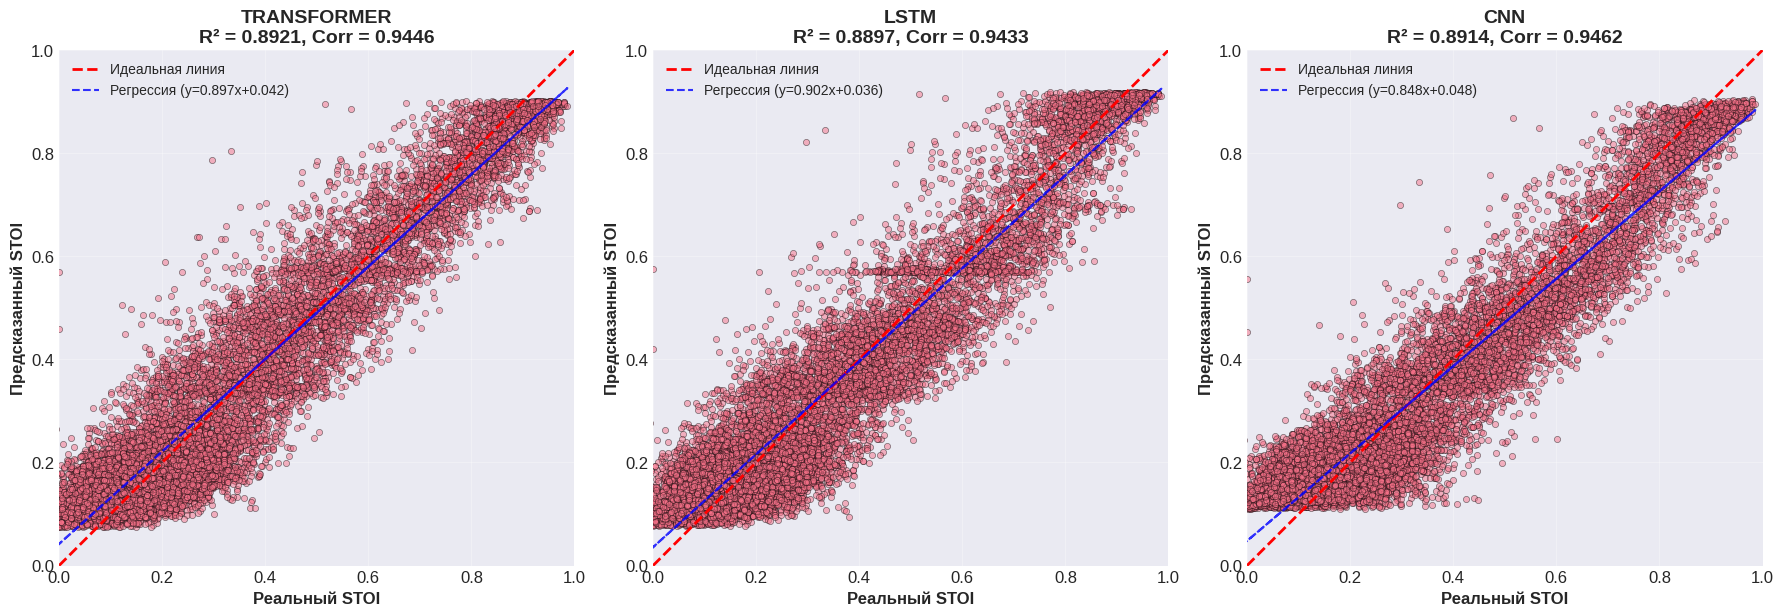

In [10]:
n_models = len(all_results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))

if n_models == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(all_results.items()):
    ax = axes[idx]
    preds = result['predictions']
    targets = result['targets']
    
    # Scatter plot
    ax.scatter(targets, preds, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Идеальная линия
    ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Идеальная линия')
    
    # Линия регрессии
    z = np.polyfit(targets, preds, 1)
    p = np.poly1d(z)
    ax.plot(targets, p(targets), "b--", alpha=0.8, linewidth=1.5, label=f'Регрессия (y={z[0]:.3f}x+{z[1]:.3f})')
    
    ax.set_xlabel('Реальный STOI', fontsize=12, fontweight='bold')
    ax.set_ylabel('Предсказанный STOI', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name.upper()}\nR² = {result["r2"]:.4f}, Corr = {result["correlation"]:.4f}', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'scatter_plots.png'), dpi=300, bbox_inches='tight')
plt.show()


### 2. Распределение ошибок


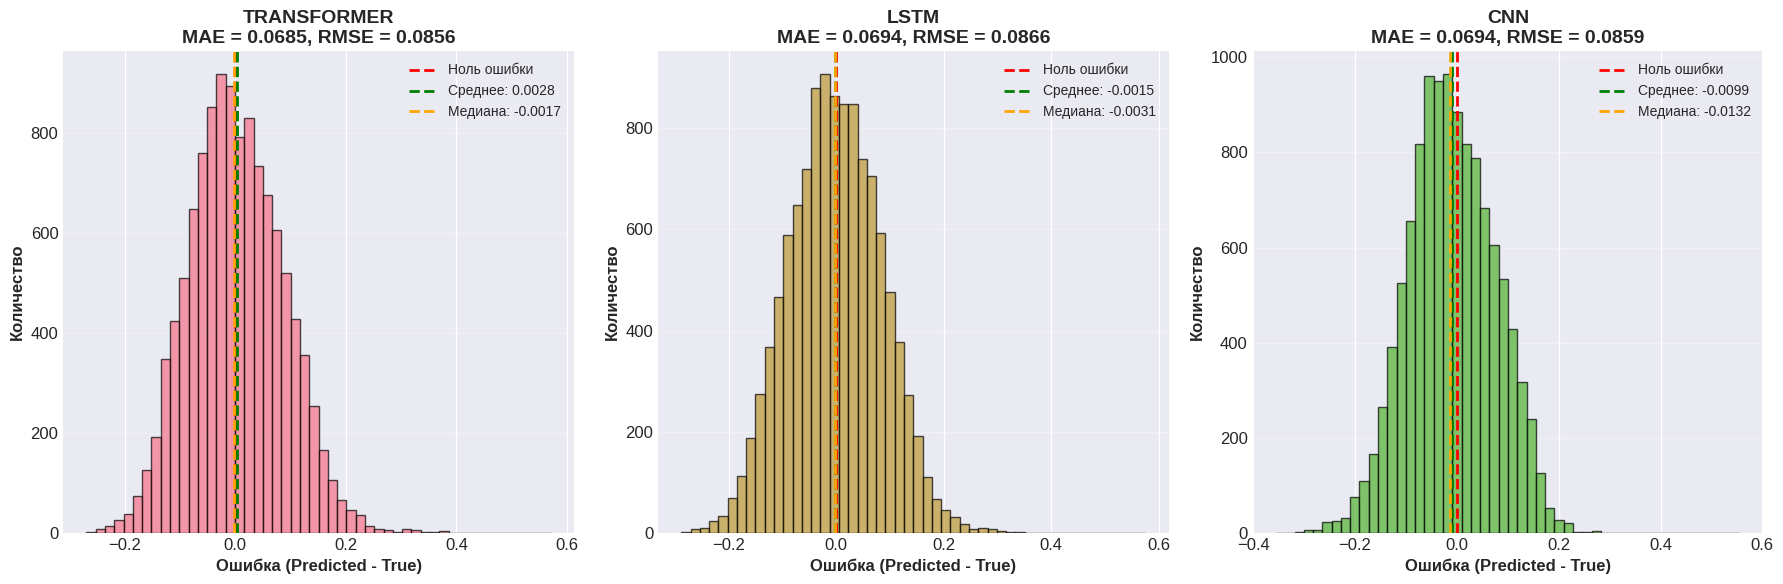

In [11]:
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))

if n_models == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(all_results.items()):
    ax = axes[idx]
    errors = result['predictions'] - result['targets']
    
    # Гистограмма ошибок
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7, color=sns.color_palette()[idx])
    
    # Вертикальная линия на нуле
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Ноль ошибки')
    
    # Среднее и медиана
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    ax.axvline(x=mean_error, color='g', linestyle='--', linewidth=2, label=f'Среднее: {mean_error:.4f}')
    ax.axvline(x=median_error, color='orange', linestyle='--', linewidth=2, label=f'Медиана: {median_error:.4f}')
    
    ax.set_xlabel('Ошибка (Predicted - True)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Количество', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name.upper()}\nMAE = {result["mae"]:.4f}, RMSE = {result["rmse"]:.4f}', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'error_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()


### 3. Сравнение метрик между моделями


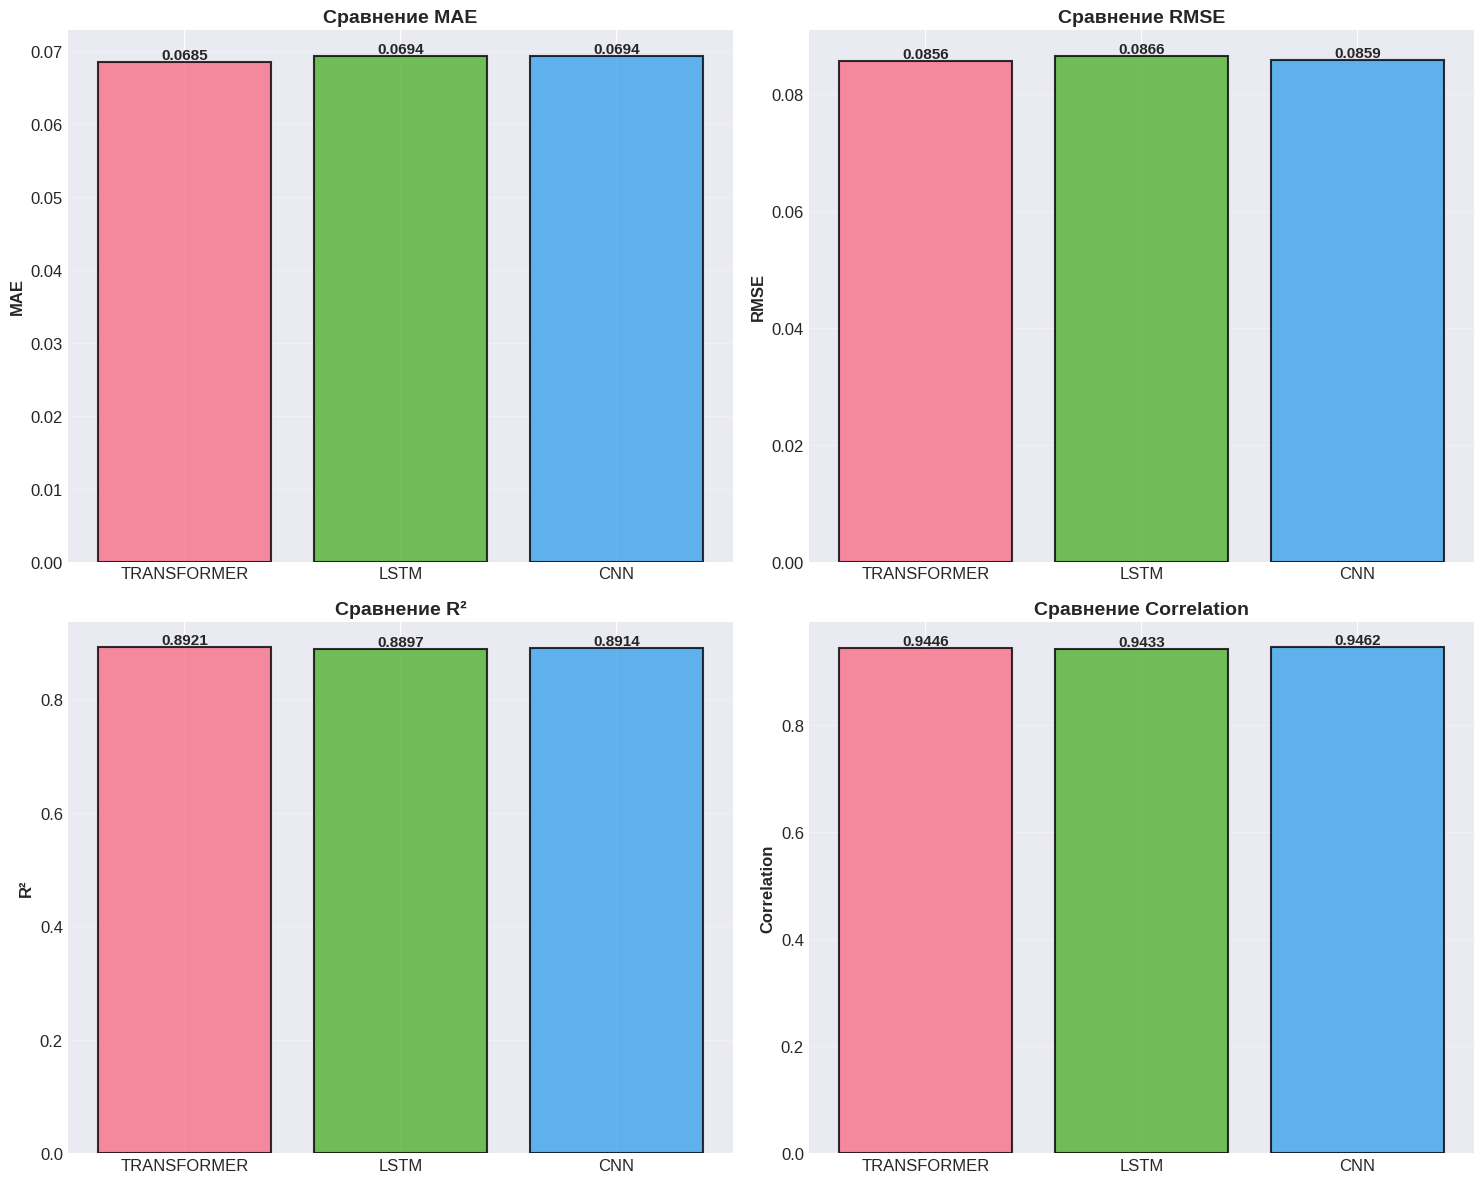


СРАВНЕНИЕ МЕТРИК
      Model      MAE     RMSE       R²  Correlation
TRANSFORMER 0.068512 0.085604 0.892072     0.944569
       LSTM 0.069389 0.086557 0.889655     0.943320
        CNN 0.069406 0.085880 0.891373     0.946240


In [12]:
# Подготовка данных для сравнения
metrics_data = []
for model_name, result in all_results.items():
    metrics_data.append({
        'Model': model_name.upper(),
        'MAE': result['mae'],
        'RMSE': result['rmse'],
        'R²': result['r2'],
        'Correlation': result['correlation']
    })

df_metrics = pd.DataFrame(metrics_data)

# Создаем фигуру с несколькими subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['MAE', 'RMSE', 'R²', 'Correlation']
colors = sns.color_palette("husl", n_models)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = df_metrics[metric].values
    bars = ax.bar(df_metrics['Model'], values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Добавляем значения на столбцы
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Сравнение {metric}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(bottom=0)
    
    # Для R² и Correlation добавляем линию на 1.0
    if metric in ['R²', 'Correlation']:
        ax.axhline(y=1.0, color='r', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Выводим таблицу
print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТРИК")
print("="*80)
print(df_metrics.to_string(index=False))
print("="*80)


### 4. Точность в пределах порогов


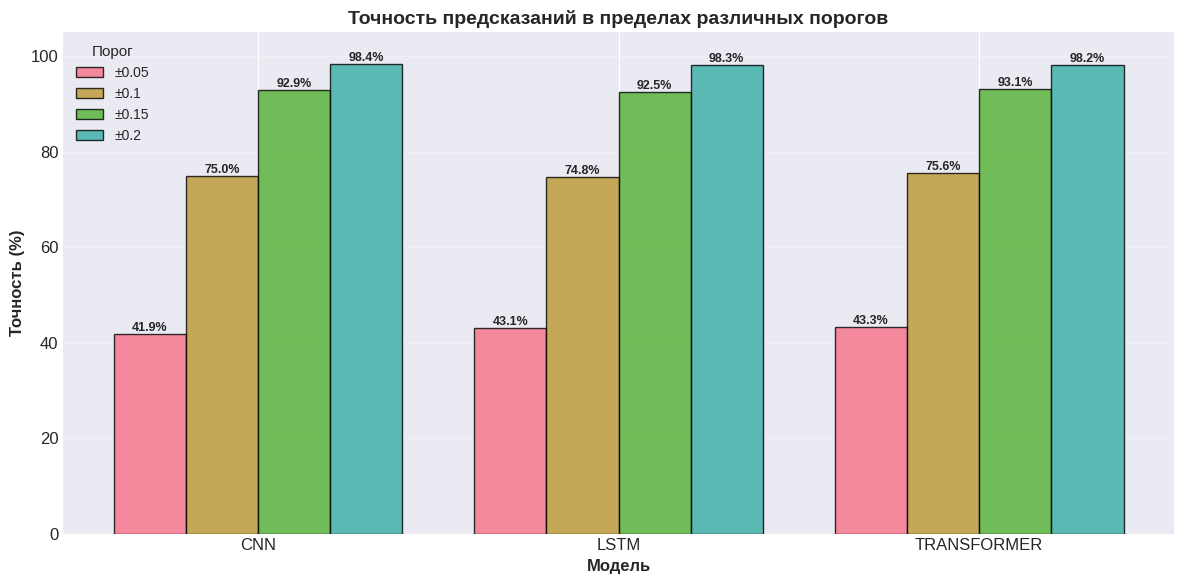


ТОЧНОСТЬ В ПРЕДЕЛАХ ПОРОГОВ
Threshold        ±0.05       ±0.1      ±0.15       ±0.2
Model                                                  
CNN          41.879230  74.995662  92.885650  98.351553
LSTM         43.128579  74.770085  92.503904  98.256117
TRANSFORMER  43.250043  75.559604  93.111227  98.247441


In [13]:
# Подготовка данных для точности
thresholds = [0.05, 0.10, 0.15, 0.20]
accuracy_data = []
for model_name, result in all_results.items():
    for threshold in thresholds:
        accuracy_data.append({
            'Model': model_name.upper(),
            'Threshold': f'±{threshold}',
            'Accuracy': result['accuracy_at_threshold'][threshold]
        })

df_accuracy = pd.DataFrame(accuracy_data)

# Создаем график
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot для удобного построения
df_pivot = df_accuracy.pivot(index='Model', columns='Threshold', values='Accuracy')

# Строим grouped bar chart
x = np.arange(len(df_pivot.index))
width = 0.2
multiplier = 0

for threshold in df_pivot.columns:
    offset = width * multiplier
    bars = ax.bar(x + offset, df_pivot[threshold], width, label=threshold, alpha=0.8, edgecolor='black')
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    multiplier += 1

ax.set_xlabel('Модель', fontsize=12, fontweight='bold')
ax.set_ylabel('Точность (%)', fontsize=12, fontweight='bold')
ax.set_title('Точность предсказаний в пределах различных порогов', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(df_pivot.columns) - 1) / 2)
ax.set_xticklabels(df_pivot.index)
ax.legend(title='Порог', fontsize=10, title_fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 105])

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_at_thresholds.png'), dpi=300, bbox_inches='tight')
plt.show()

# Выводим таблицу
print("\n" + "="*80)
print("ТОЧНОСТЬ В ПРЕДЕЛАХ ПОРОГОВ")
print("="*80)
print(df_accuracy.pivot(index='Model', columns='Threshold', values='Accuracy').to_string())
print("="*80)


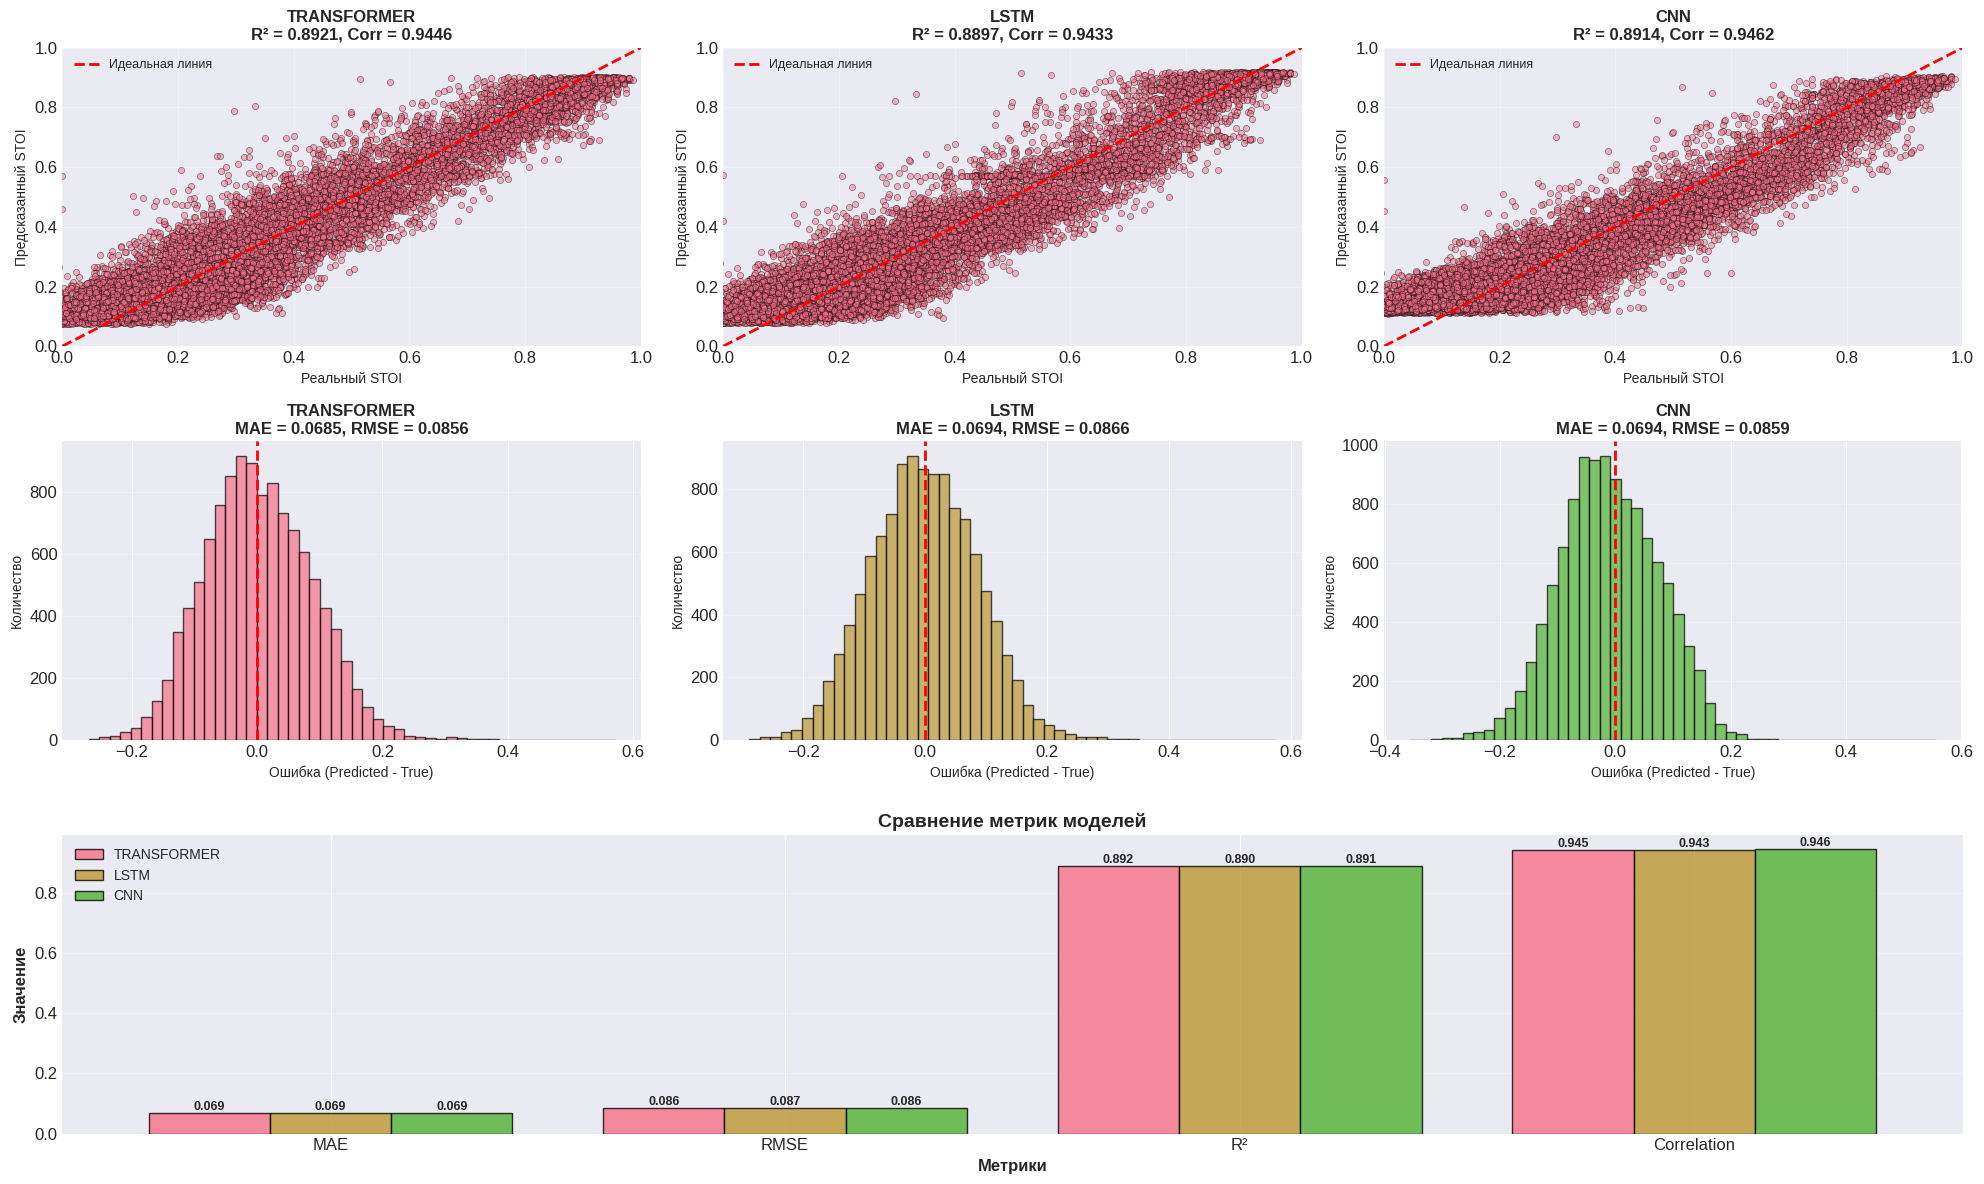

In [14]:
# Создаем большую фигуру со всеми графиками
fig = plt.figure(figsize=(20, 12))

# 1. Scatter plots
for i, (model_name, result) in enumerate(all_results.items()):
    ax = plt.subplot(3, n_models, i + 1)
    preds = result['predictions']
    targets = result['targets']
    
    ax.scatter(targets, preds, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Идеальная линия')
    ax.set_xlabel('Реальный STOI', fontsize=10)
    ax.set_ylabel('Предсказанный STOI', fontsize=10)
    ax.set_title(f'{model_name.upper()}\nR² = {result["r2"]:.4f}, Corr = {result["correlation"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

# 2. Гистограммы ошибок
for i, (model_name, result) in enumerate(all_results.items()):
    ax = plt.subplot(3, n_models, n_models + i + 1)
    errors = result['predictions'] - result['targets']
    
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7, color=sns.color_palette()[i])
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Ошибка (Predicted - True)', fontsize=10)
    ax.set_ylabel('Количество', fontsize=10)
    ax.set_title(f'{model_name.upper()}\nMAE = {result["mae"]:.4f}, RMSE = {result["rmse"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# 3. Сравнение метрик (bar plot)
ax = plt.subplot(3, 1, 3)
metrics = ['MAE', 'RMSE', 'R²', 'Correlation']
x = np.arange(len(metrics))
width = 0.8 / n_models

for i, (model_name, result) in enumerate(all_results.items()):
    values = [
        result['mae'],
        result['rmse'],
        result['r2'],
        result['correlation']
    ]
    offset = (i - n_models/2 + 0.5) * width
    bars = ax.bar(x + offset, values, width, label=model_name.upper(), alpha=0.8, edgecolor='black')
    
    # Добавляем значения
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Метрики', fontsize=12, fontweight='bold')
ax.set_ylabel('Значение', fontsize=12, fontweight='bold')
ax.set_title('Сравнение метрик моделей', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'full_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


### 6. Детальная таблица сравнения


In [15]:
# Создаем детальную таблицу
comparison_table = []
for model_name, result in all_results.items():
    info = model_info.get(model_name, {})
    comparison_table.append({
        'Модель': model_name.upper(),
        'Эпоха': info.get('epoch', 'N/A'),
        'Val Loss': f"{info.get('val_loss', 'N/A'):.4f}" if isinstance(info.get('val_loss'), float) else info.get('val_loss', 'N/A'),
        'Val MAE': f"{info.get('val_mae', 'N/A'):.4f}" if isinstance(info.get('val_mae'), float) else info.get('val_mae', 'N/A'),
        'Test MAE': f"{result['mae']:.4f}",
        'Test RMSE': f"{result['rmse']:.4f}",
        'Test R²': f"{result['r2']:.4f}",
        'Test Corr': f"{result['correlation']:.4f}",
        'Acc ±0.05': f"{result['accuracy_at_threshold'][0.05]:.2f}%",
        'Acc ±0.10': f"{result['accuracy_at_threshold'][0.10]:.2f}%",
        'Acc ±0.15': f"{result['accuracy_at_threshold'][0.15]:.2f}%",
        'Acc ±0.20': f"{result['accuracy_at_threshold'][0.20]:.2f}%"
    })

df_comparison = pd.DataFrame(comparison_table)

print("\n" + "="*120)
print("ДЕТАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*120)
print(df_comparison.to_string(index=False))
print("="*120)

# Сохраняем в CSV
csv_path = os.path.join(OUTPUT_DIR, 'detailed_comparison.csv')
df_comparison.to_csv(csv_path, index=False)
print(f"\nТаблица сохранена в: {csv_path}")



ДЕТАЛЬНОЕ СРАВНЕНИЕ МОДЕЛЕЙ
     Модель  Эпоха Val Loss Val MAE Test MAE Test RMSE Test R² Test Corr Acc ±0.05 Acc ±0.10 Acc ±0.15 Acc ±0.20
TRANSFORMER     20   0.0074  0.0698   0.0685    0.0856  0.8921    0.9446    43.25%    75.56%    93.11%    98.25%
       LSTM      9   0.0078  0.0711   0.0694    0.0866  0.8897    0.9433    43.13%    74.77%    92.50%    98.26%
        CNN     11   0.0077  0.0712   0.0694    0.0859  0.8914    0.9462    41.88%    75.00%    92.89%    98.35%

Таблица сохранена в: ./comparison_results/detailed_comparison.csv


## Сохранение результатов в JSON


In [16]:
# Подготовка данных для сохранения
comparison_data = {
    'timestamp': datetime.now().isoformat(),
    'test_samples': len(dataset),
    'models_info': model_info,
    'results': {}
}

for model_name, result in all_results.items():
    comparison_data['results'][model_name] = {
        'mae': float(result['mae']),
        'mse': float(result['mse']),
        'rmse': float(result['rmse']),
        'r2': float(result['r2']),
        'correlation': float(result['correlation']),
        'accuracy_at_threshold': {str(k): float(v) for k, v in result['accuracy_at_threshold'].items()}
    }

# Сохраняем в JSON
json_path = os.path.join(OUTPUT_DIR, 'comparison_metrics.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(comparison_data, f, indent=2, ensure_ascii=False)

print(f"Результаты сохранены в: {json_path}")
print("\n✓ Сравнение моделей завершено!")
print(f"Все графики сохранены в директории: {OUTPUT_DIR}")


Результаты сохранены в: ./comparison_results/comparison_metrics.json

✓ Сравнение моделей завершено!
Все графики сохранены в директории: ./comparison_results
